In [2]:
# Use modules from parent directory
import os
import sys
import tifffile as tiff
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000   
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from srcv2_2.models.params import get_params
from srcv2_2.models.Unet import Unet, UnetV2
from srcv2_2.visualization.make_image_files import visualize_test_data, __visualize_landsat8_tile__
from srcv2_2.visualization.visualization_utils import get_predicted_thumbnails 
from srcv2_2.utils import get_model_name

import tensorflow as tf

2024-02-23 14:41:54.673181: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 14:41:54.691618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 14:41:54.691636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 14:41:54.692065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 14:41:54.695453: I tensorflow/core/platform/cpu_feature_guar

## Load KERAS Model

In [3]:
params = get_params('U-net', 'Landsat8')
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
activation_func='relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.modelID = "Test_Local"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

In [4]:
local_loaded_model = tf.keras.saving.load_model(f"../models/Unet/{get_model_name(params)}.keras")
# weights and funcs will automatically be loaded

unet_loaded_local_model = UnetV2(params, model=local_loaded_model)

2024-02-23 14:41:57.553492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 14:41:57.571987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 14:41:57.572067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load MODIS file(s)

In [5]:
modis_path = "/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530.hdf"

from osgeo import gdal

In [6]:
day1_hdf = gdal.Open(modis_path + day1)
day1_subsets = day1_hdf.GetSubDatasets()

/home/mxh/anaconda3/envs/tf2+gpu/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
day1_subsets

[('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:num_observations_1km',
  '[1200x1200] num_observations_1km MODIS_Grid_1km_2D (8-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:state_1km_1',
  '[1200x1200] state_1km_1 MODIS_Grid_1km_2D (16-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorZenith_1',
  '[1200x1200] SensorZenith_1 MODIS_Grid_1km_2D (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorAzimuth_1',
  '[1200x1200] SensorAzimuth_1 MODIS_Grid_1km_2D (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Vol

In [18]:
day1_state_1km = gdal.Open('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:state_1km_1').ReadAsArray()
day1_sur_refl_b04 = gdal.Open('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1').ReadAsArray()
day1_sur_refl_b05 = gdal.Open('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1').ReadAsArray()

### plot for vis

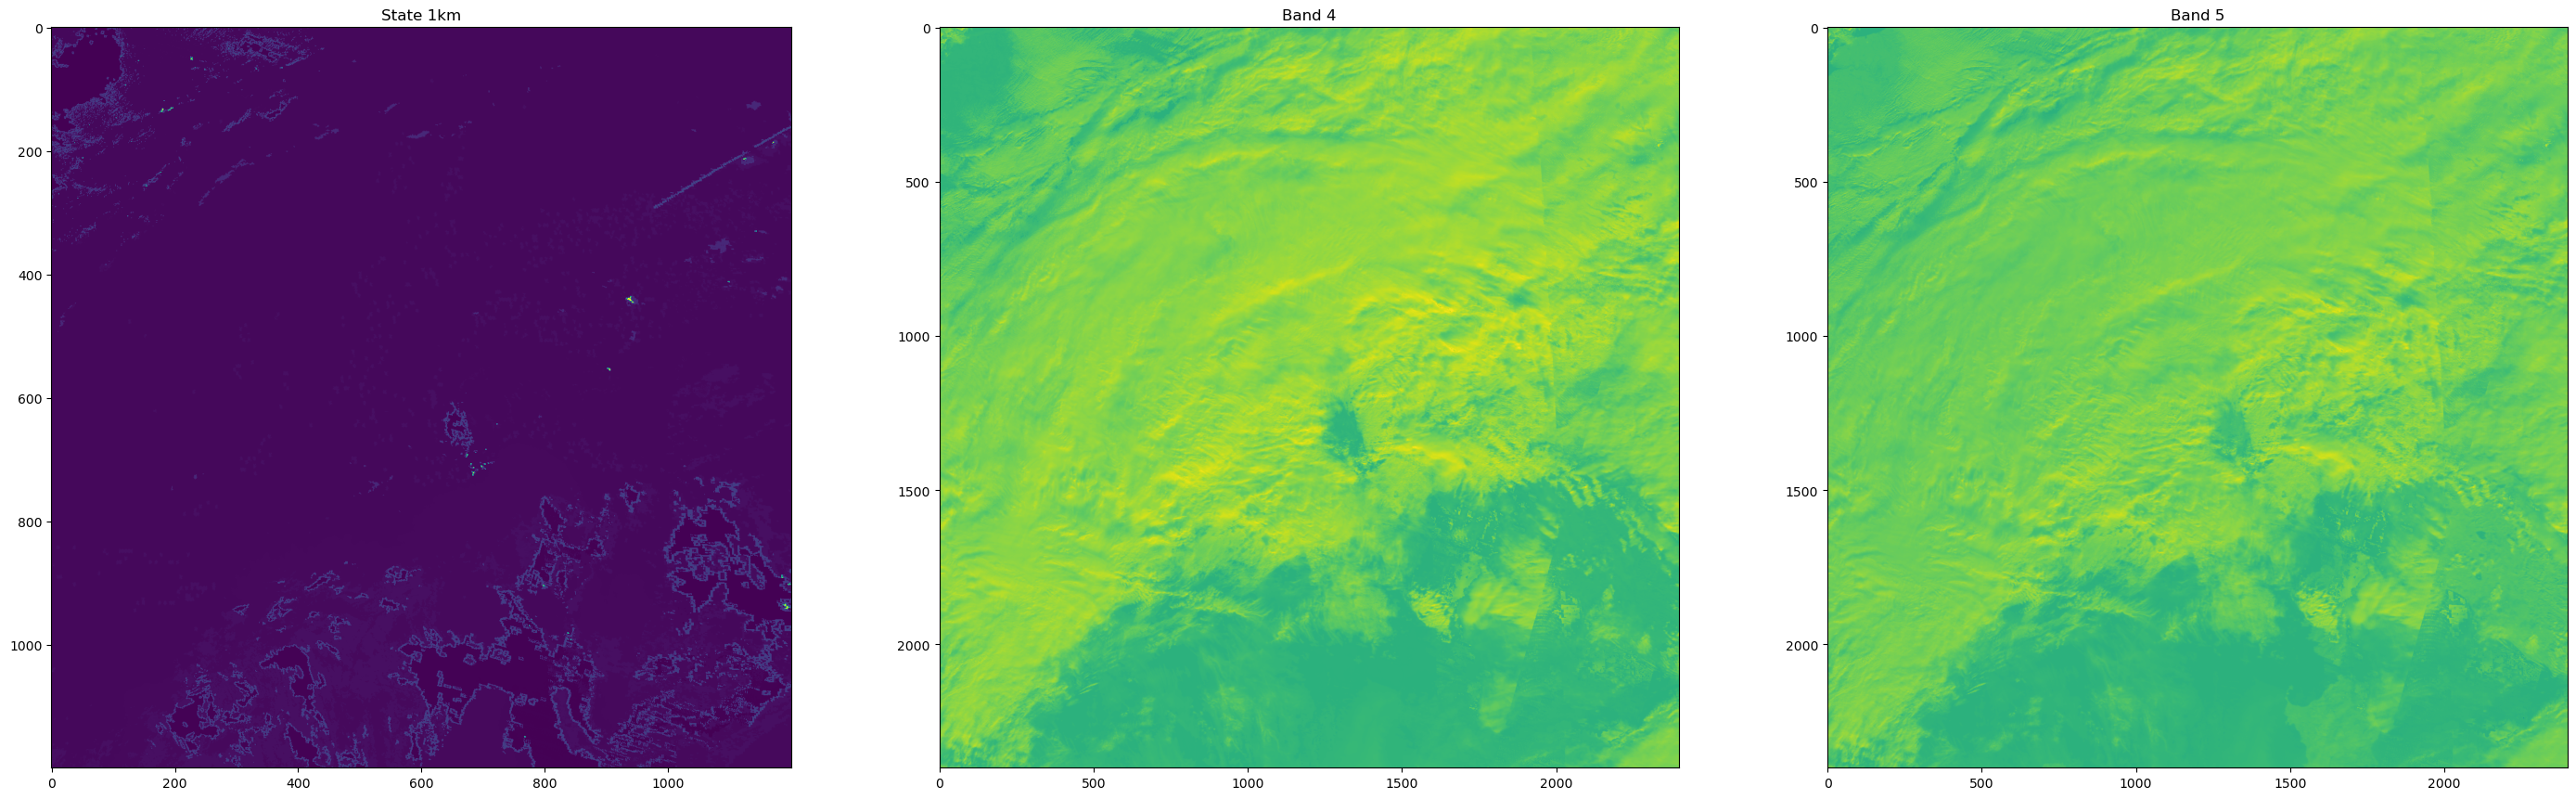

In [19]:
plt.figure(figsize=(35, 35))

plt.subplot(1, 3, 1)
plt.title('State 1km' )
plt.imshow(day1_state_1km)

plt.subplot(1, 3, 2)
plt.title('Band 4')
plt.imshow(day1_sur_refl_b04)

plt.subplot(1, 3, 3)
plt.title('Band 5' )
plt.imshow(day1_sur_refl_b05)

plt.show()

In [20]:
# convert to TIFF for Unet input?


# copy toa func from sis_GenerateBiome_TOA notebook
def _create_toa_file_MODIS(data_path, toa_path):
    print('Processing product: ' + data_path +' into ' + toa_path)
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}ref.img {data_path}LC8*_B[1-7,9].TIF
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}thermal.img {data_path}LC8*_B1[0,1].TIF
    
    !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {data_path}*_MTL.txt -t {data_path}ref.img -o {data_path}angles.img                
    !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {data_path}ref.img -m {data_path}*_MTL.txt -o {data_path}saturationmask.img
    !mkdir -p {toa_path}
    !{fmask_path}fmask_usgsLandsatTOA.py -i {data_path}ref.img -m {data_path}*_MTL.txt -z {data_path}angles.img -o {data_path}toa.img        

    # Translate to .tif file
    !{gdal_path}gdal_translate -of Gtiff {data_path}toa.img {toa_path + data_path[-22:-1]}_toa.TIF

    # Delete all intermediate files
    !rm {data_path}*.img {data_path}*.xml

# plan is to create TOA file for MODIS file, as this will be needed for Unet prediction
# https://semiautomaticclassificationmanual.readthedocs.io/en/latest/tutorial_1.html
    # https://modis.gsfc.nasa.gov/data/atbd/atbd_mod11.pdf

## Run KERAS Model on MODIS file